In [1]:
import utils 
import transformer 
import bar_distribution
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import prior 
matplotlib.use('TkAgg')
%matplotlib inline
import main
import importlib
device = torch.device("cuda")
importlib.reload(utils)
importlib.reload(transformer)
importlib.reload(bar_distribution)
importlib.reload(main)
importlib.reload(prior)
import random
#####################################################################################################################################################
import warnings 
warnings.filterwarnings("ignore")

In [2]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
num_epochs = 100
lr = 0.001
num_outputs = 10
seq_len = 100
batch_size = 200
in_features = 2
noise = False
warm_up_epochs = 5
std_variation=True
model = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = utils.get_cosine_schedule_with_warmup(optimizer, warm_up_epochs, num_epochs)
model.criterion = criterion

Using device: Quadro P1000
total params:2113034


In [3]:
%matplotlib inline
trains= main.train(model, criterion, num_epochs, optimizer, scheduler, batch_size,seq_len, in_features, num_classes=num_outputs,std_variation=std_variation)

| epoch  10 | lr 0.0009901899829374047 || validation loss 1.491
| epoch  20 | lr 0.000931628240478787 || validation loss 1.450
| epoch  30 | lr 0.0008262928807620843 || validation loss 1.399
| epoch  40 | lr 0.0006855986244591103 || validation loss 1.407
| epoch  50 | lr 0.0005247918773366112 || validation loss 1.374
| epoch  60 | lr 0.00036129854561907783 || validation loss 1.352
| epoch  70 | lr 0.0002128356686585282 || validation loss 1.330
| epoch  80 | lr 9.549150281252633e-05 || validation loss 1.322
| epoch  90 | lr 2.198210923282118e-05 || validation loss 1.323
training completed in 481.94 seconds


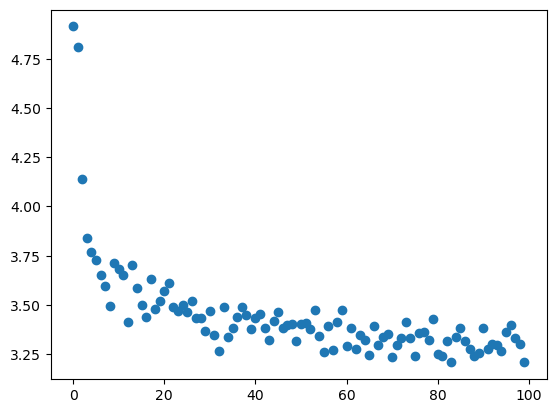

In [18]:
%matplotlib inline
plt.scatter(np.arange(num_epochs), trains, label="training loss")
plt.show()

In [28]:
%matplotlib inline
temp_batch_size = 10
train_X, train_Y, y_target, batch_classes = prior.sample_dirichlet_clusters(batch_size=temp_batch_size,seq_len=seq_len, num_features=2, num_classes=5)
model.eval()
print("") 

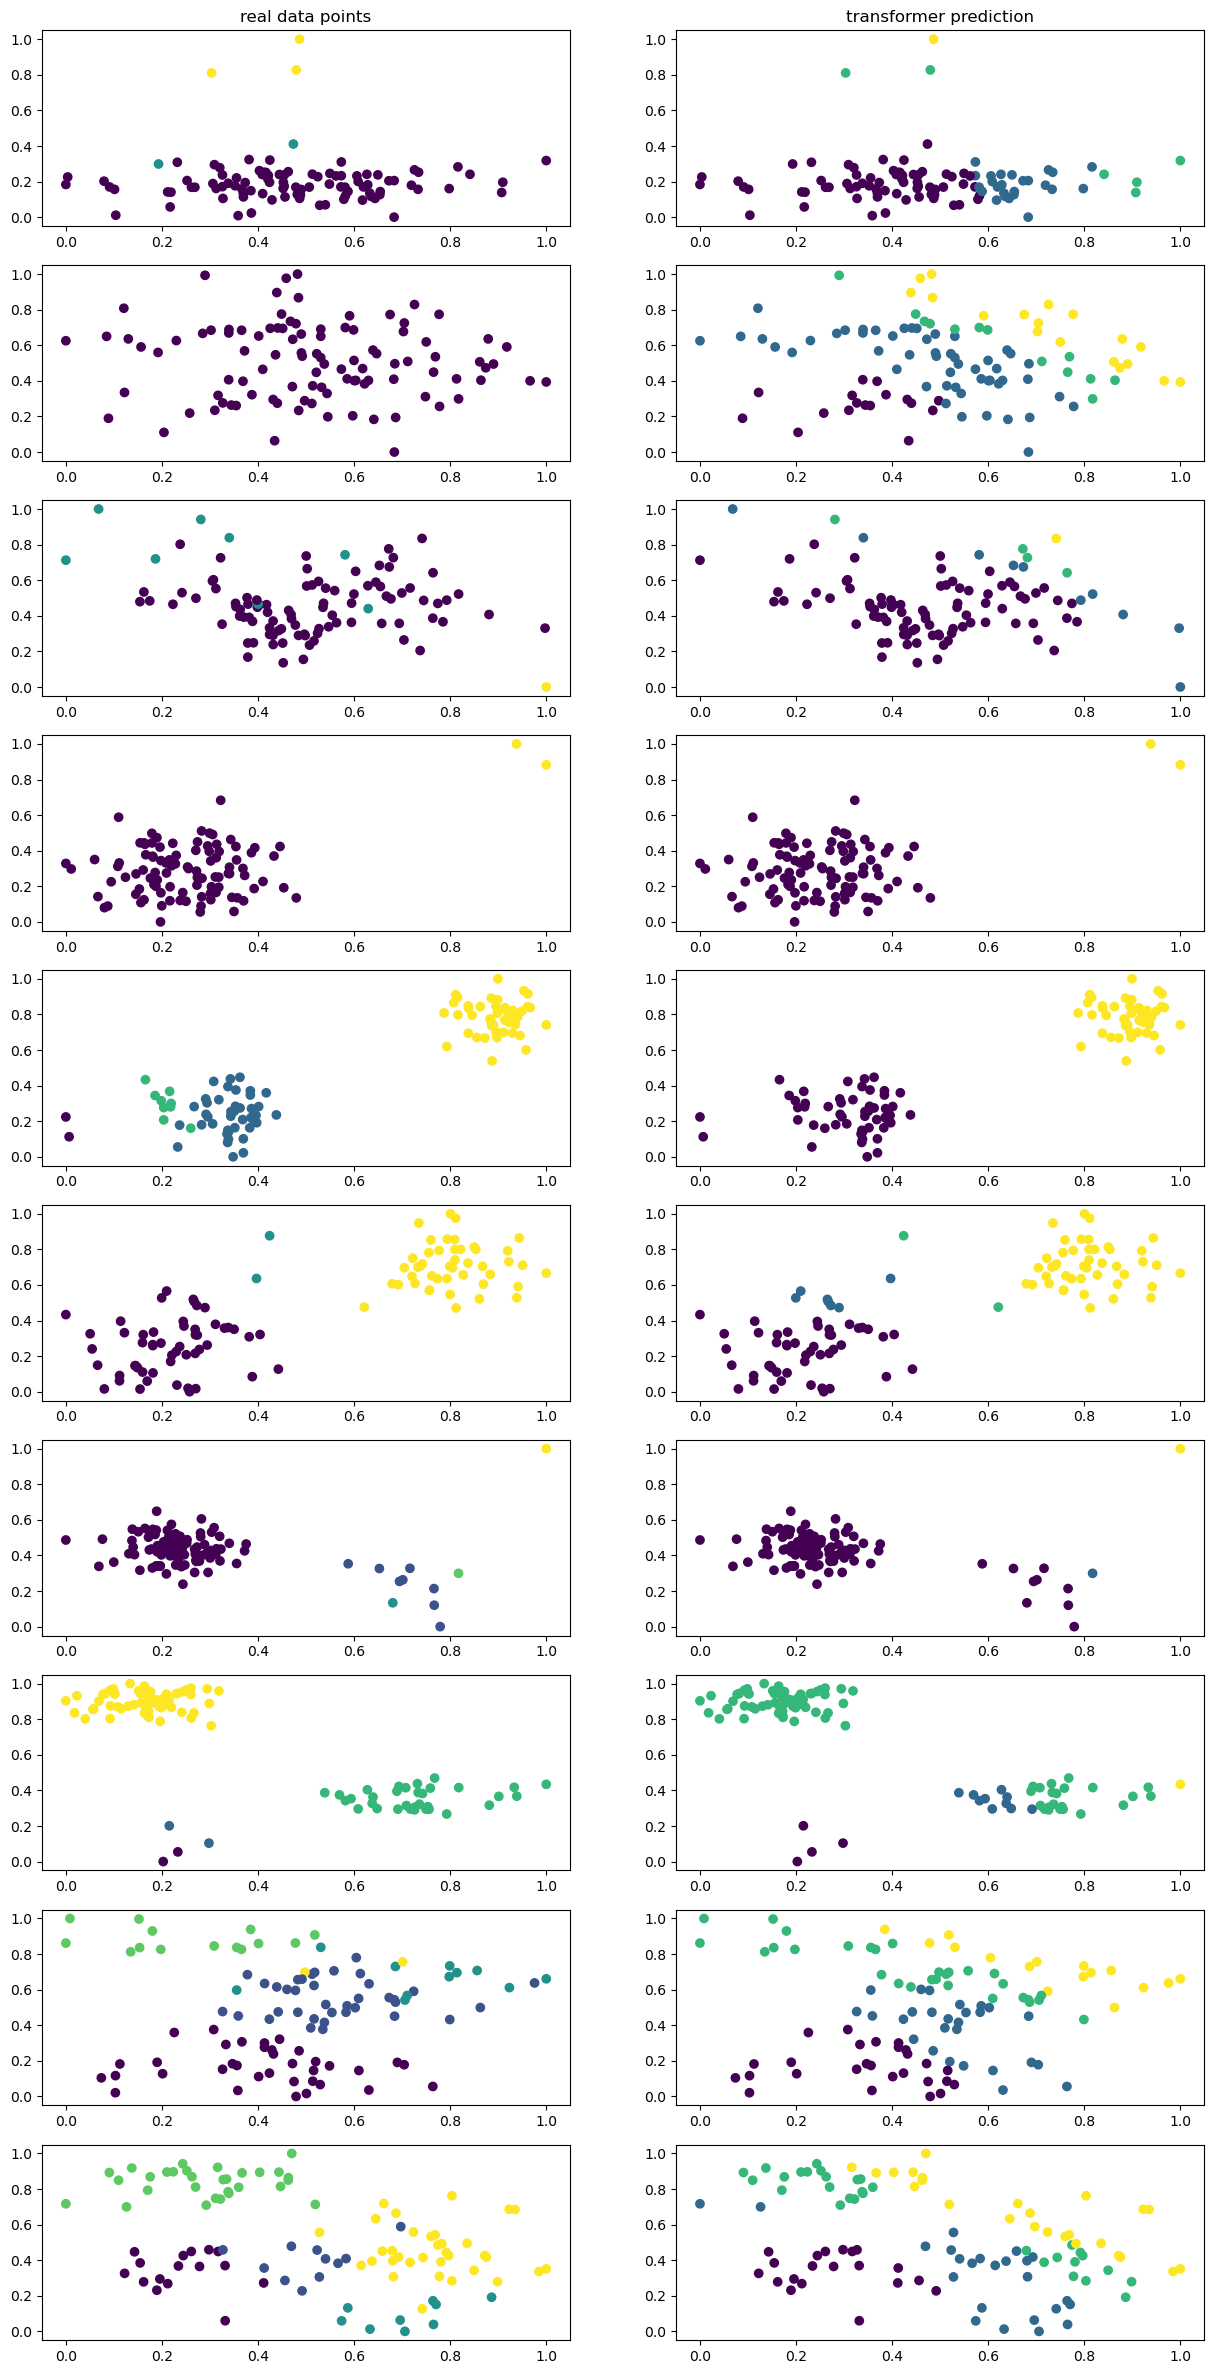

In [29]:
# # Set up grid for subplots
fig, axes = plt.subplots(temp_batch_size, 2, figsize=(15, 30)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x = train_X[:, batch_index].unsqueeze(1)
    train_y = train_Y[:, batch_index] 
    axes[2 * batch_index].scatter(train_x[:, 0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=train_y.cpu().numpy())
    logits,cluster_output = model(train_x)
    logits = logits.squeeze(1)
    cluster_output = cluster_output.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    predictions_cluster_count = torch.argmax(cluster_output, dim=1)
    axes[2 * batch_index +1].scatter(train_x[:,0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())
    #axes[2 * batch_index + 1].text(0.9, 0.9, f"clusters:{predictions_cluster_count.cpu().item() + 1}") 

axes[1].set_title(f"transformer prediction")
axes[0].set_title(f"real data points")
plt.show()

In [359]:
def sample_dirichlet_process_gaussians(n_samples=500, alpha=1.0, dim=2, base_mean=0, base_cov=10):
    max_clusters = 10
    # Base measure (Gaussian prior for means of clusters)
    base_mean = np.zeros(dim) if isinstance(base_mean, (int, float)) else np.array(base_mean)
    base_cov = np.eye(dim) * base_cov if isinstance(base_cov, (int, float)) else np.array(base_cov)
    correlation_strength= 0
    # Stick-breaking process to determine cluster weights
    betas = np.random.beta(1, alpha, size=n_samples)
    pis = betas * np.cumprod(np.hstack([[1], 1 - betas[:-1]]))  # Stick-breaking probabilities

    # Assign samples to clusters
    cluster_indices = np.random.choice(min(len(pis), max_clusters), size=n_samples, p=pis[:max_clusters]/np.sum(pis[:max_clusters]))
    unique_clusters = np.unique(cluster_indices)
    mapping = {unique_clusters[i] : i for i in range(len(unique_clusters))}
    unique_clusters_mapped = [mapping.get(x) for x in unique_clusters]
    cluster_indices_mapped =  [mapping.get(x) for x in cluster_indices]
    print(unique_clusters_mapped)
    # Sample cluster means and covariances
    cluster_means = {k: np.random.multivariate_normal(base_mean, base_cov) for k in unique_clusters_mapped}
    cluster_covs = {k: np.eye(dim) * (0.5 + np.random.rand(dim,dim)) for k in unique_clusters_mapped}  # Random covariances
    #cluster_covs = {}
    # for k in unique_clusters_mapped:
    #     random_cov = np.random.rand(dim, dim)
    #     correlated_cov = (random_cov + random_cov.T) / 2  # Make symmetric
    #     np.fill_diagonal(correlated_cov, 1)
    #     correlated_cov *= correlation_strength  # Scale correlation strength
    #     cluster_covs[k] = np.dot(correlated_cov, correlated_cov.T)  # Ensure positive semi-definiteness

    # Generate data points
    X = np.array([multivariate_normal.rvs(mean=cluster_means[k], cov=cluster_covs[k]) for k in cluster_indices_mapped])
    return X, cluster_indices_mapped

[0, 1, 2, 3, 4, 5, 6, 7]


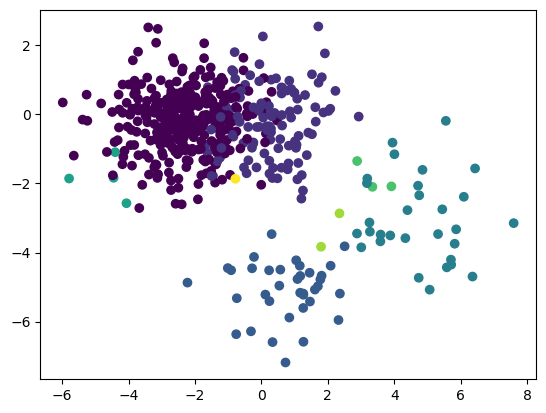

In [377]:
X, cluster_indices = sample_dirichlet_process_gaussians()
plt.scatter(X[:, 0] , X[:, 1], c=cluster_indices)
plt.show()

[0.46946973 0.77282851 0.28178821 0.96812606 0.87099659]
[1.         0.53053027 0.22717149 0.71821179 0.03187394] [1.         0.53053027 0.12052135 0.08655986 0.002759  ]
[0.46946973 0.41000891 0.0339615  0.08380085 0.00240308]
